<a href="https://colab.research.google.com/github/forminju/deeplearning-practice/blob/main/0103_%ED%95%A9%EC%84%B1%EA%B3%B1_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%BB%B4%ED%93%A8%ED%84%B0_%EB%B9%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 컴퓨터 비전

- CNN 의 배경, 구성요소
- CNN 구현
- 객체 탐지 (이미지 하나에서 여러 가지 객체 구분하고 객체 주위에 바운딩 박스 그리는 작업)
- 시맨틱 분할 (물체가 속한 클래스에 따라 픽셀을 구분하는 방법) 

# 합성곱이란?

- 합성곱은 한 함수가 다른 함수 위를 이동하면서 원소별 곱셈의 적분을 계산하는 수학연산. 푸리에 변환 및 라플라스 변환과 깊은 관계가 있으며 신호 처리 분야에서 많이 사용된다.

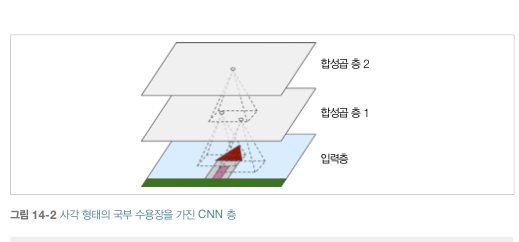

- 첫 번째 합성곱 층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결된다. 두 번째 합성곱 층에 있는 각 뉴런은 첫 번쨰 층의 작은 사각 영역 안에 위치한 뉴런에 연결된다. 이런 구조는 네트워크가 첫 번째 은닉층에서는 적은 저수준 특성에 집중하고, 그다음 은닉층에서는 더 큰 고수준 특성으로 조합하도록 도와준다.
- 이런 계층적 구조는 실제 이미지에서 흔히 볼 수 있으며, 이는 CNN이 이미지 인식에 잘 작동하는 이유 중 하나이다.

- 제로 패딩 
- 스트라이드
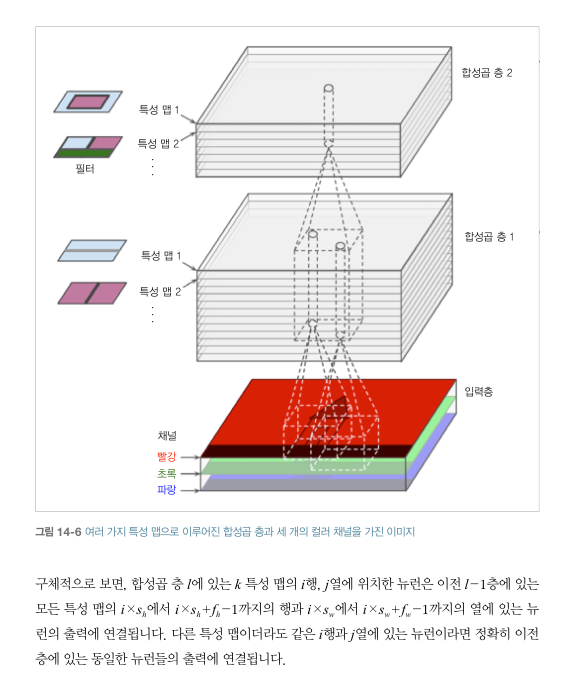

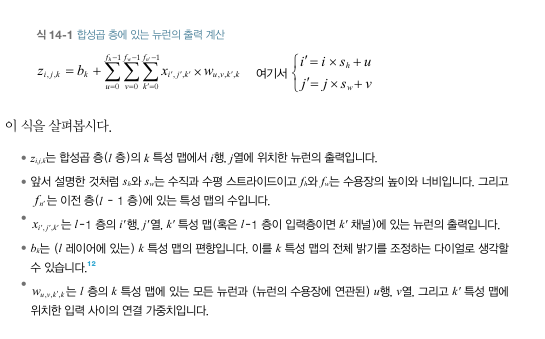

In [2]:
# 텐서플로 구현
# 텐서플로에서 각 입력 이미지는 보통 [높이 너비, 채널] 형태의 3D 텐서로 표현된다. 하나의 미니배치는 [미니배치 크기, 높이, 너비, 채널] 형태의 4D 텐서로 표현된다.

In [4]:
! pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
# 각 컬러 채널의 픽셀 강도는 0에서 255 사이의 값을 가진 바이트 하나로 표현된다.
# 이 특성을 255로 나누어 0에서 1 사이의 실수로 바꾼다.

In [17]:
images = np.array([china, flower])
china = np.array([china])
batch_size, height, width, channels = images.shape

<function matplotlib.pyplot.show(*args, **kw)>

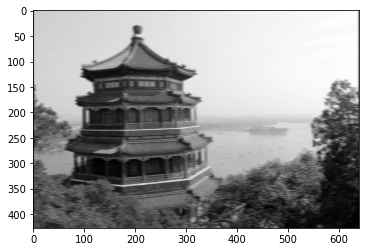

In [19]:
filters = np.zeros(shape = (7,7, channels, 2), dtype = np.float32)
# 7x7 필터를 만든다.
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

outputs = tf.nn.conv2d(images, filters, strides= 1, padding = "SAME")
# strides : 1이나 4개의 원소를 갖는 1D 배열로 지정 가능하다.
# 1D 배열의 가운데 두 개의 원소는 수직, 수평 스트라이드이고, 현재는 첫 번째와 마지막 원소가 1이어야 한다.
# padding은 "VALID" 와 "SAME" 중 하나를 지정한다.
# VALID 지정 시 합성곱 층에 제로 패딩을 사용하지 않는다.

plt.imshow(outputs[0,:,:,1], cmap="gray")
plt.show

In [13]:
# conv = keras.layers.Conv2D(filters = 32, kernel_size=3, strides=1, padding="same", activation="relu")
# 3x3 크기의 32개 필터와 스트라이드 1, same 패딩을 사용하는 Conv2D 층을 만들고 출력을 위해 ReLU 활성화 함수 적용.

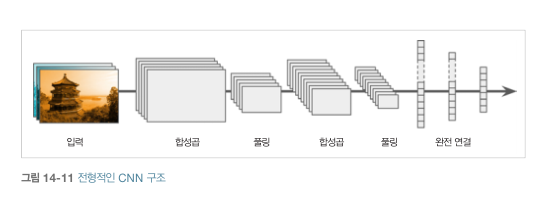

In [21]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64,7, activation = "relu", padding = "same",
                        input_shape = [28,28,1]),
    keras.layers.MaxPooling2D(2),
    # 풀링 크기가 2인 최대 풀링 층을 추가하여 공간 방향 차원을 절반으로 줄인다.
    keras.layers.Conv2D(128,3,activation="relu", padding = "same"),
    keras.layers.Conv2D(128,3, activation="relu", padding = "same"),
    # 동일한 구조를 두 번 반복한다. 최대 풀링 층이 뒤따르는 합성곱 층이 두 번 등장한다.
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256,3,activation="relu", padding = "same"),
    keras.layers.Conv2D(256,3, activation="relu", padding = "same"),
    # CNN이 출력층에 다다를수록 필터 개수가 늘어난다. 저수준 특성의 개수는 적지만 이를 연결하여 고수준 특성을 만들 수 있는 방법이
    # 많기 떄문에 이런 구조가 합리적이다.
    # 풀링 층 다음에 필터 개수를 두 배로 늘리는 것이 일반적인 방법이다.
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    # 두 개의 은닉층과 하나의 출력층으로 구성된 완전 연결 네트워크.
    # 밀집 네트워크는 샘플의 특성으로 1D 배열을 기대하므로 입력을 일렬로 펼쳐야 한다.
    # 또 밀집 층 사이에 과대적합을 줄이기 위해 50%의 드롭아웃 비율을 가진 드롭아웃 층을 추가한다.
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")                    
])

## 케라스를 사용해 ResNet-34 CNN 구현하기
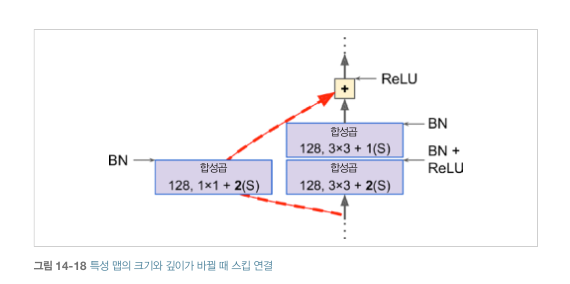

In [23]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation = "relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
        keras.layers.Conv2D(filters, 3, strides = strides,
                            padding = "same", use_bias = False),
        keras.layers.BatchNormalization(),
        self.activation,
        keras.layers.Conv2D(filters, 3, strides = 1,
                            padding = "same", use_bias = False),
        keras.layers.BatchNormalization()] 
   
   # 오른쪽 모델     

    self.skip_layers = []
    if strides > 1 :
       self.skip_layers = [
           keras.layers.Conv2D(filters, 1, strides = strides,
                               padding = "same", use_bias = False),
           keras.layers.BatchNormalization()]

   # 왼쪾 모델        

  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)

    return self.activation(Z + skip_Z)            


In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides = 2, input_shape =[224,224,3],
                              padding = "same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters == prev_filters else 2 
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters
# 처음 3개 RU는 64개 필터, 다음 4개 RU는 128개 필터 가지는 식.
# 필터의 개수가 이전 RU와 동일할 경우 스트라이드 1  
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))  